In [122]:
# Library import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [123]:
# Load the data
# data file is located in folder data
df = pd.read_csv('./data/heart.csv')
print(df.head())
print(df.tail())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193     

In [124]:
# Check if the dataset has any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [125]:
# Map sex category variable to numeric values
# (0 denote Male and 1 denote Female)
mapping = {'M':0, 'F':1}
df['Sex'] = df['Sex'].replace(mapping)
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 86.2+ KB
   Age  Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0   40    0           ATA        140          289          0     Normal   
1   49    1           NAP        160          180   

In [126]:
# Find unique values for chest pain type
print(df['ChestPainType'].unique())

['ATA' 'NAP' 'ASY' 'TA']


In [127]:
# Map chest pain type category variable to numeric values
# 0 denote atypical angina (ATA)
# 1 denote non-anginal pain (NAP)
# 2 denote asymptomatic (ASY)
# 3 denote typical angina (TA)
mapping = {'ATA':0, 'NAP':1, 'ASY':2, 'TA':3}
df['ChestPainType'] = df['ChestPainType'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0   40    0              0        140          289          0     Normal   
1   49    1              1        160          180

In [128]:
# Find unique values for resting ECG
print(df['RestingECG'].unique())


['Normal' 'ST' 'LVH']


In [129]:
# Map resting ECG category variable to numeric values
# 0 denote Normal
# 1 denote ST-T wave abnormality (ST)
# 2 denote left ventricular hypertrophy (LVH)
mapping = {'Normal':0, 'ST':1, 'LVH':2}
df['RestingECG'] = df['RestingECG'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          1

In [130]:
# Map exercise angina category variable to numeric values
# 0 denote No
# 2 denote Yes
mapping = {'N':0, 'Y':1}
df['ExerciseAngina'] = df['ExerciseAngina'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          

In [131]:
# Find unique values for resting ECG
print(df['ST_Slope'].unique())


['Up' 'Flat' 'Down']


In [132]:
# Map resting ECG category variable to numeric values
# 0 denote Up
# 1 denote Flat
# 2 denote Down
mapping = {'Up': 0, 'Flat': 1, 'Down': 2}
df['ST_Slope'] = df['ST_Slope'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          180         

In [133]:
df.describe()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.210240,1.452070,132.396514,198.799564,0.233115,0.603486,136.809368,0.404139,0.887364,0.638344,0.553377
std,9.432617,0.407701,0.851832,18.514154,109.384145,0.423046,0.805968,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,0.000000,1.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,2.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,0.000000,2.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,1.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


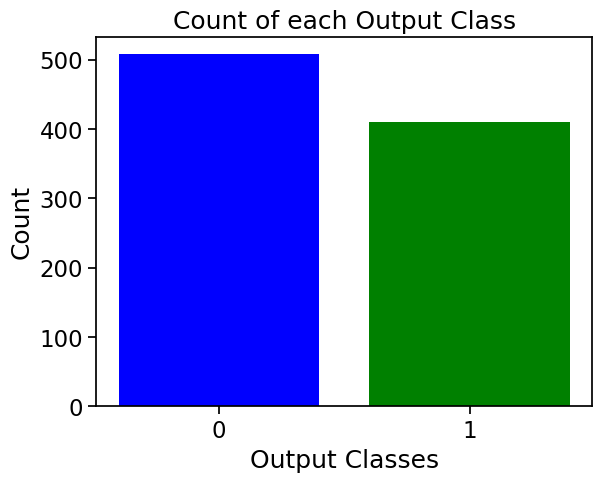

In [134]:
# Check if the dataset is balanced
# Count the number of Heart Disease (1) and Normal (0)
plt.bar(df['HeartDisease'].unique(), df['HeartDisease'].value_counts(), color = ['blue', 'green'])
plt.xticks([0, 1])
plt.xlabel('Output Classes')
plt.ylabel('Count')
plt.title('Count of each Output Class')
plt.savefig('figures/OutputClassBalance.jpg')

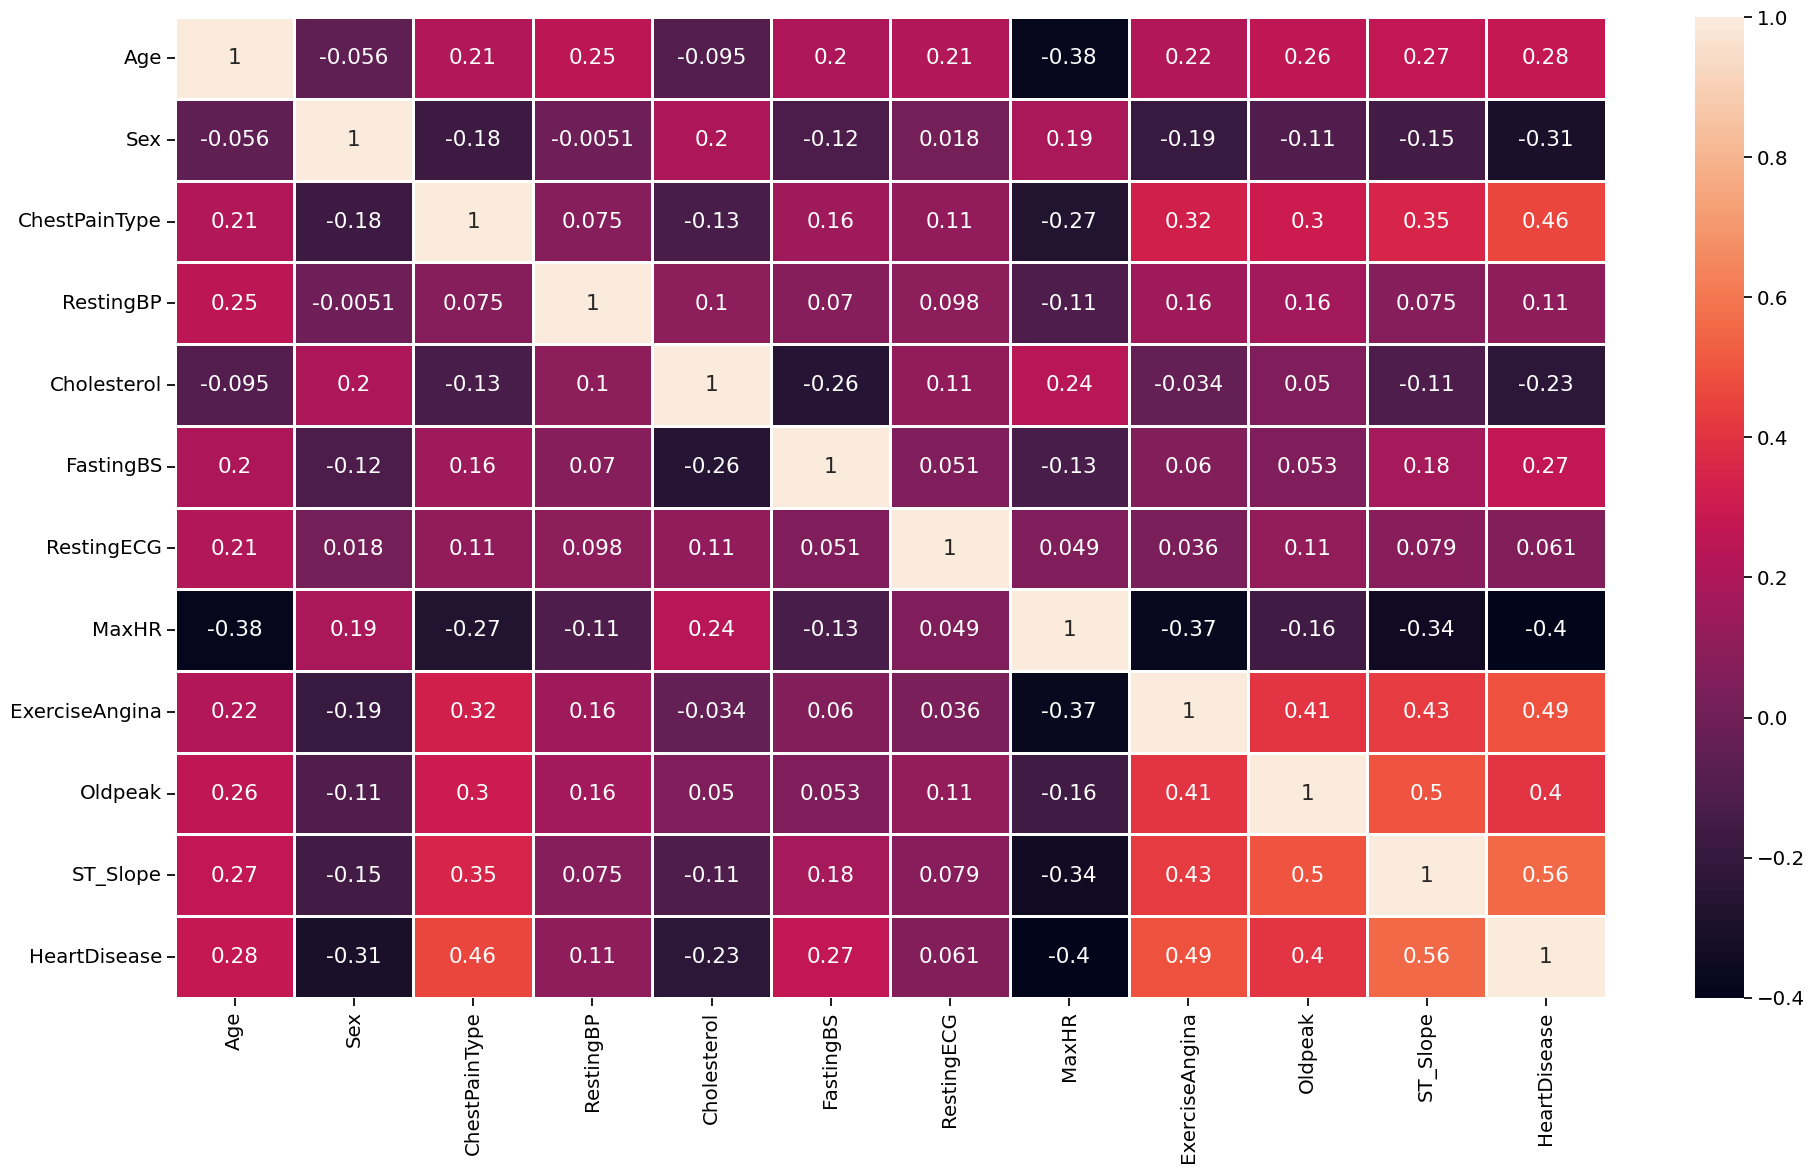

In [135]:
# Generate correlation matrix between all features
plt.figure(figsize=(20,12))
sns.set_context('notebook',font_scale = 1.3)
sns.heatmap(df.corr(),annot=True,linewidth =2)
plt.tight_layout()
plt.savefig('figures/CorrelationMatrix.jpg')

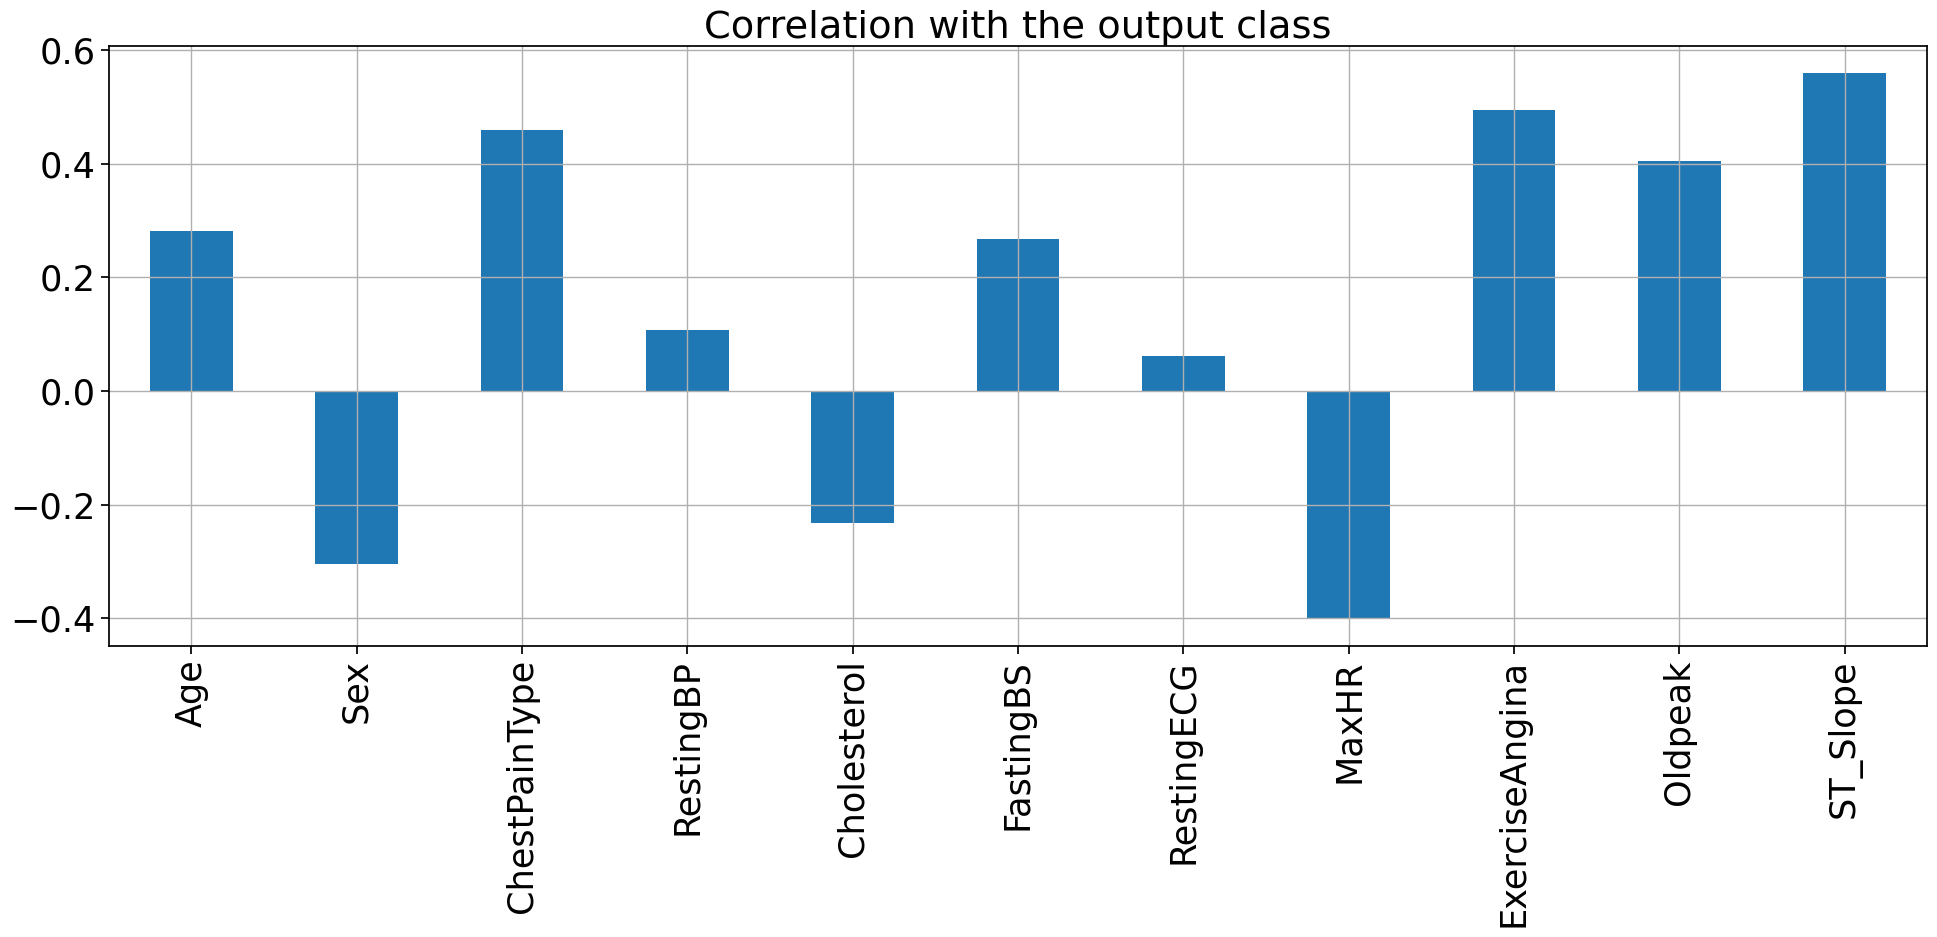

In [136]:
# Identify relationship between each feature and the output class
sns.set_context('notebook',font_scale = 2.3)
df.drop('HeartDisease', axis=1).corrwith(df.HeartDisease).plot(kind='bar', grid=True, figsize=(20, 10), title="Correlation with the output class")
plt.tight_layout()
plt.savefig('figures/OutputCorrelation.jpg')

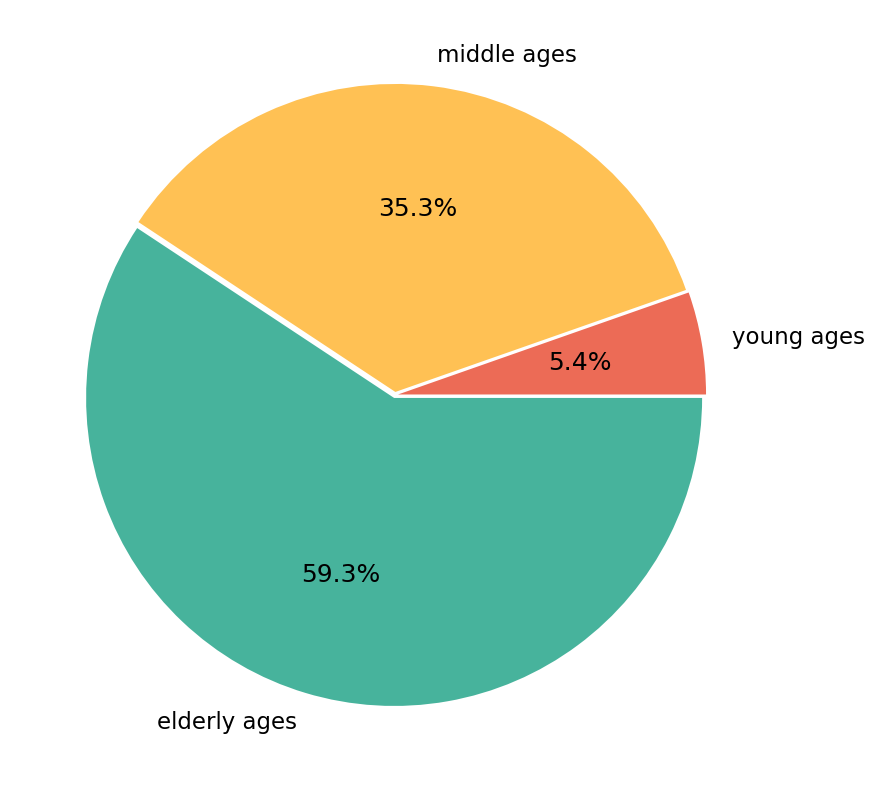

In [137]:
# Plot pie chart for age group vs. heart disease
young = df[(df.Age>=28) & (df.Age<40) & (df.HeartDisease==1)]
middle = df[(df.Age>=40)&(df.Age<55)&(df.HeartDisease==1)]
old = df[(df.Age>55)&(df.HeartDisease==1)]

colors = ['#EC6B56','#FFC154','#47B39C']
plt.figure(figsize=(23,10))
sns.set_context('notebook',font_scale = 1.5)
plt.pie([len(young),len(middle),len(old)],labels=['young ages','middle ages','elderly ages'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%')
plt.savefig('figures/AgeGroup.jpg')

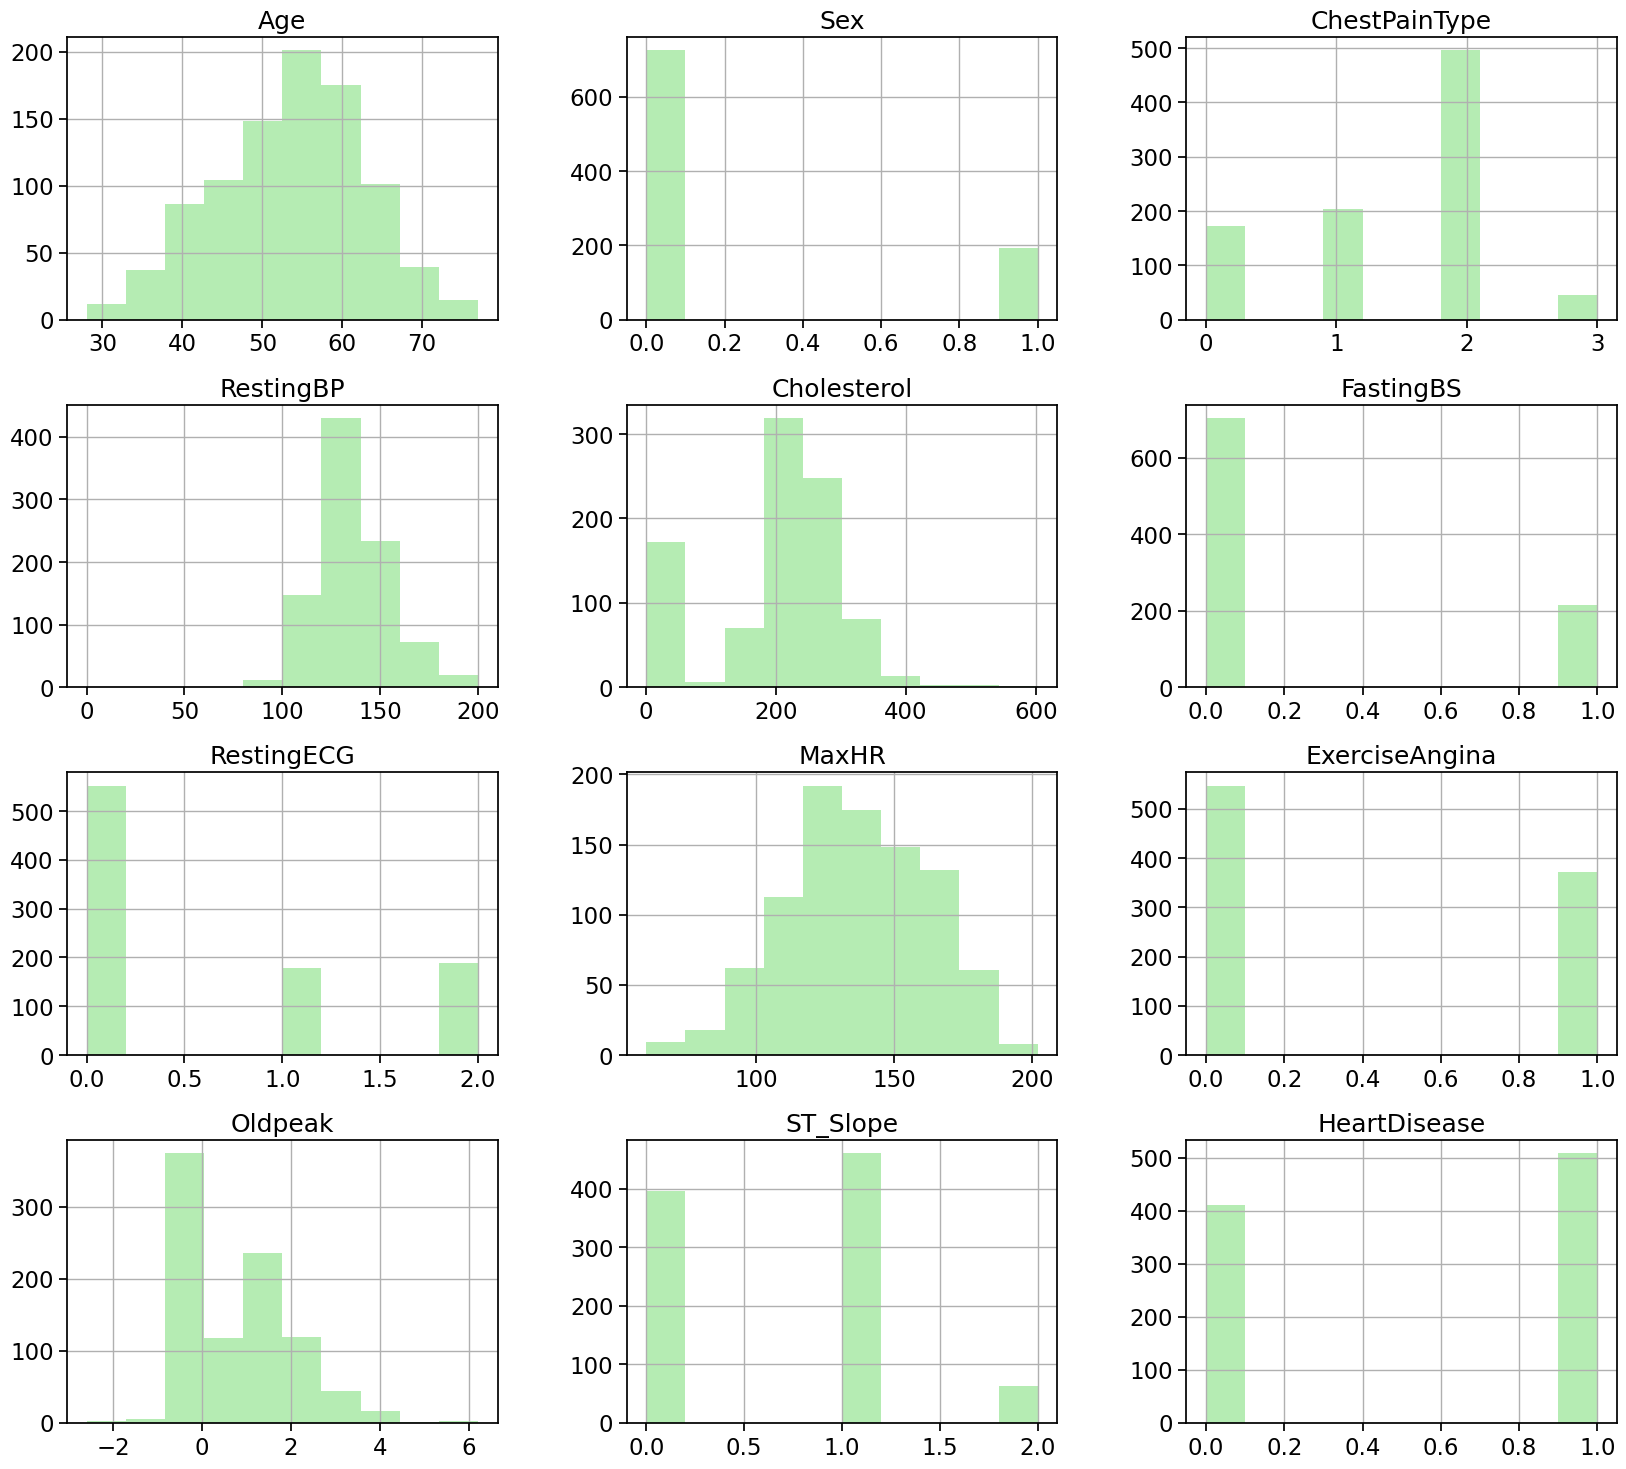

In [138]:
# Find distribution of dataset
df.hist(figsize=(20,18), color = '#B5ECB3')
plt.savefig('figures/HistogramAll.jpg')

A mixture of categorical variables and continuous variables. Continuous variables (age, restingbp, cholesterol, maxhr, oldpeak) need to be scaled since they have different range. Categorical should be divided into dummy columns separating each value.
